In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Path to your .h5 file
file_path = '../results/2025-02-14/10/000055472-A7_Cat_Wigner_2D_AWG.h5'
#000044695-A6_VdP1mode_Wigner_AWG_Cam.h5'
#000043982-A6_Displacement_Wigner_AWG_Cam.h5'
#27408-A2_Displace_Wigner_2D.h5'
#4_Vdp_Wigner_2D.h5'
#-A2_Displace_Wigner_2D.h5'
#-A4_Vdp_Wigner_2D.h5'

# Open the .h5 file in read mode
with h5py.File(file_path, 'r') as file:
    # Print the names of the groups/datasets in the file
    print("Keys in the file:", list(file.keys()))
    
    # Assuming there's a dataset named 'data' in the file
    # Modify this part according to your file's structure
    data = file['datasets']
    print(file['datasets'].keys())

    print(file['archive'].keys())
    #print(file['archive']['__param__SDF'].keys())

    print(file['expid'][()])


    rabi_t= data['beta_index'][:]
    pmt_count=data['pmt_counts_avg_thresholded'][:]

plt.figure()
plt.plot(rabi_t, pmt_count)
plt.scatter(rabi_t, pmt_count,c='red',s=20)
plt.xlabel('${\\rm t}(\mu s)$')
plt.ylabel('<z>')





In [3]:
pmt_count=pmt_count.reshape(int(np.sqrt(len(pmt_count))),int(np.sqrt(len(pmt_count))))
#pmt_count[pmt_count<0.0001]=np.nan
# pmt_count[pmt_count>0.595]=np.nan

In [4]:
eta1=0.0944#0.0944
eta2=0.0944#0.0717
Rabi_readout1=0.1*2*np.pi
Rabi_readout2=0.1*2*np.pi
beta_time_range_us1 = 40
beta_time_range_us2 = 40

beta_range1=eta1*Rabi_readout1*beta_time_range_us1
beta_range2=eta2*Rabi_readout2*beta_time_range_us2

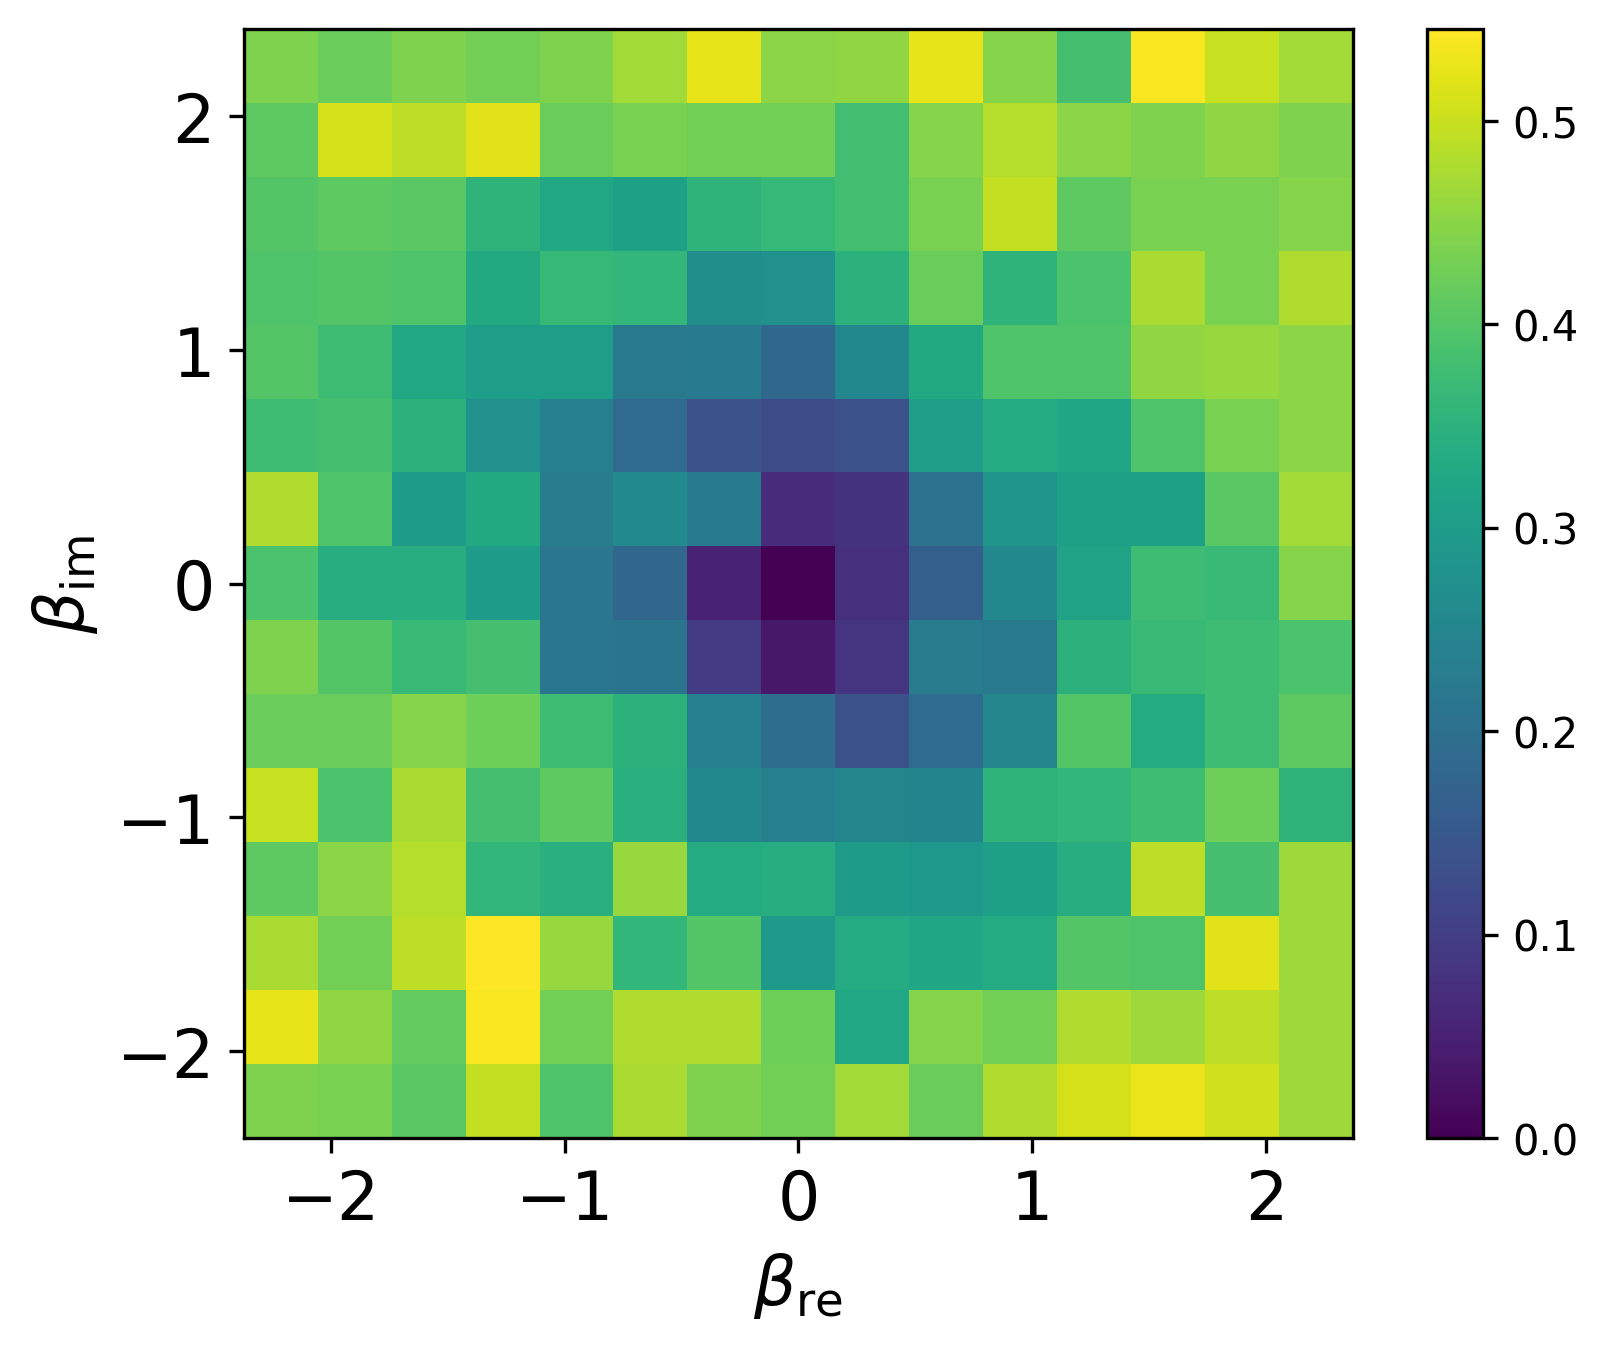

In [5]:
import matplotlib.colors as mcolors
cmap = plt.cm.viridis  # You can choose any colormap
cmap = cmap.copy()     # Copy the colormap to modify it
cmap.set_bad(color='gray')  # Set NaN values to gray

# pmt_count[pmt_count>0.7]=np.nan

plt.figure(dpi=300)

plt.imshow(pmt_count, cmap=cmap, extent=[-beta_range1,beta_range1,-beta_range2,beta_range2], aspect=beta_range1/beta_range2)
plt.xlabel('$\\beta_{\\rm re}$',fontsize=16)
plt.ylabel('$\\beta_{\\rm im}$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar()

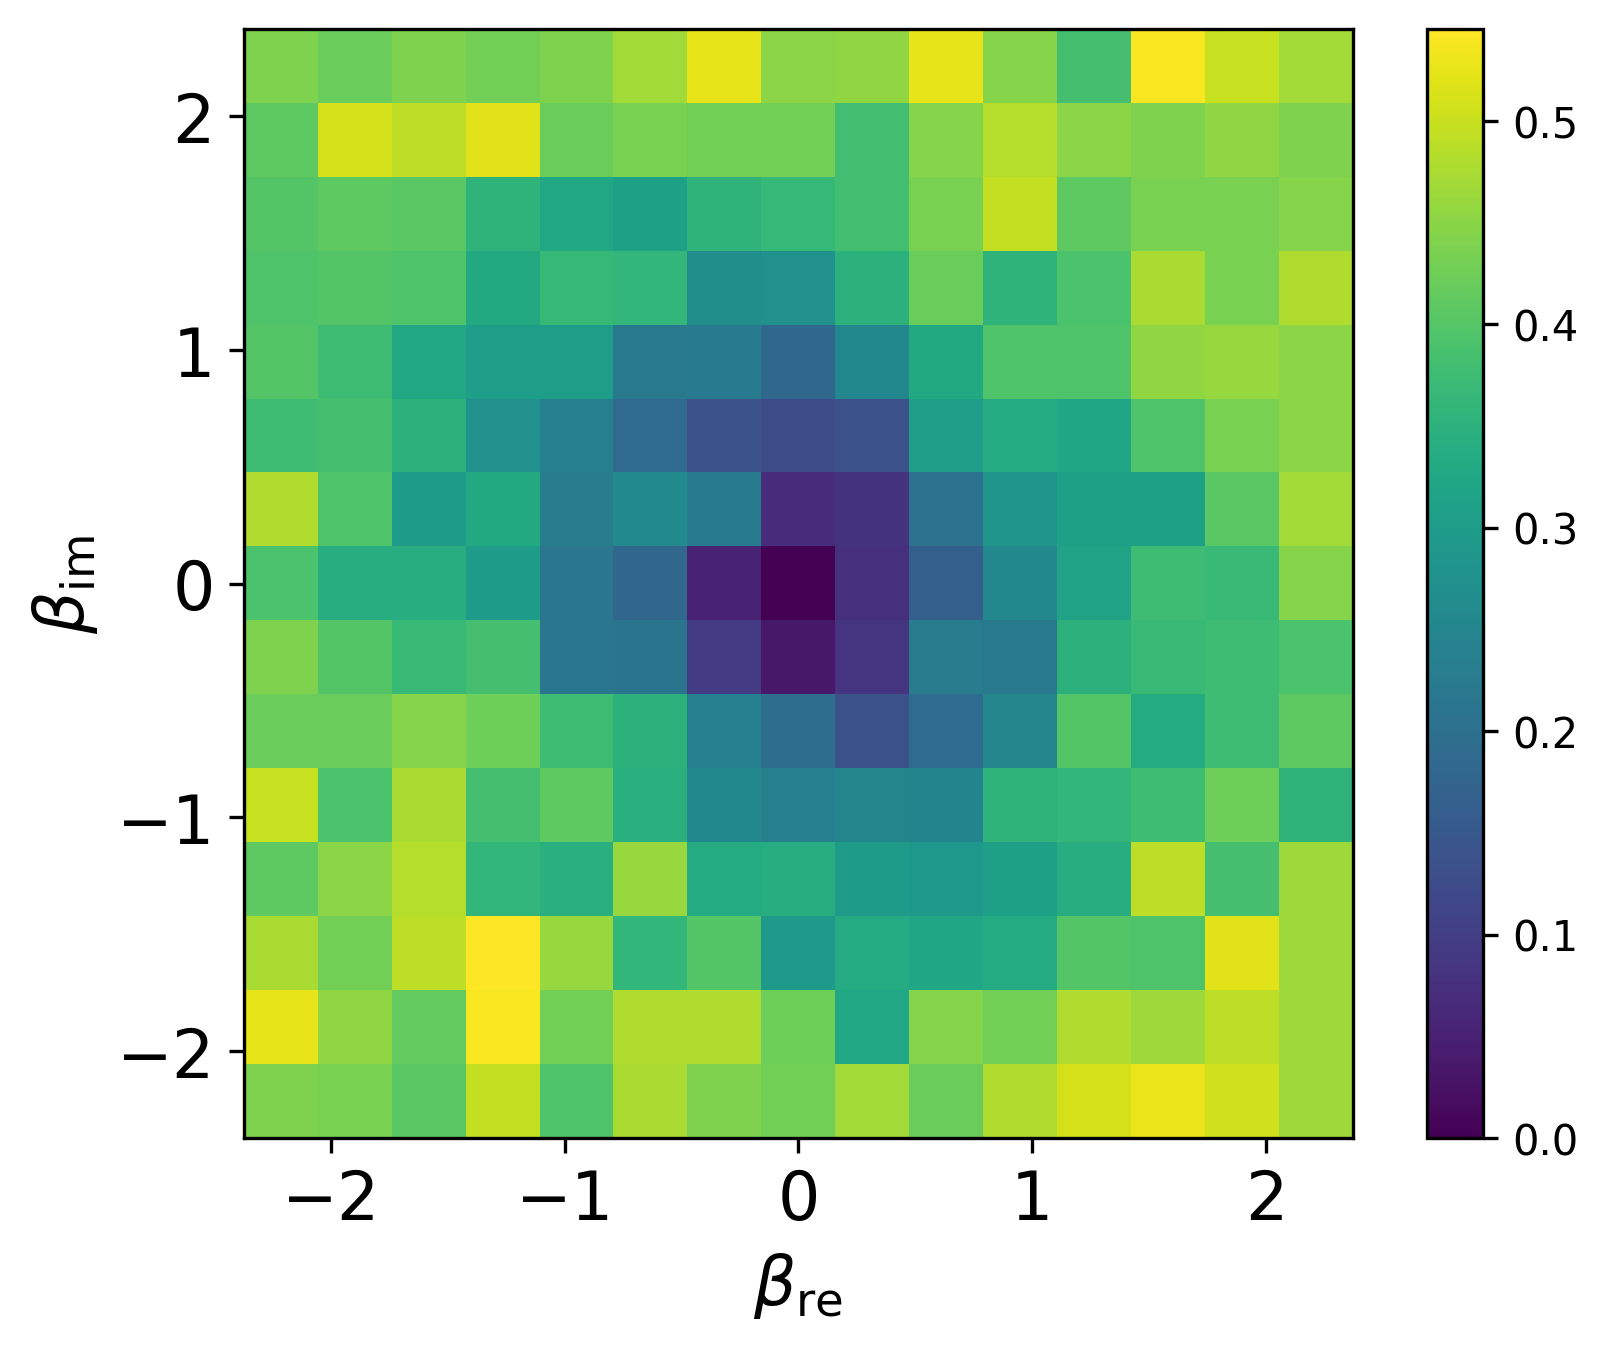

In [6]:
from scipy.ndimage import zoom


def interpolate_2d(data, upscale_factor=2, method='bicubic', padding=0):
    """
    Interpolates a 2D array to a higher resolution grid and then applies optional zero padding.
    
    Parameters:
        data (np.ndarray): 2D input array.
        upscale_factor (int): Factor by which to upscale the resolution.
        method (str): Interpolation method, choices are 'bilinear' or 'bicubic'.
        padding (int): Number of zero-padding layers around the data.
        
    Returns:
        np.ndarray: Interpolated high-resolution 2D array with padding.
    """
    if method == 'bilinear':
        order = 1
    elif method == 'bicubic':
        order = 3
    else:
        raise ValueError("Invalid method. Choose 'bilinear' or 'bicubic'.")
    
    interpolated_data = zoom(data, zoom=upscale_factor, order=order)
    
    if padding > 0:
        interpolated_data = np.pad(interpolated_data, pad_width=padding, mode='constant', constant_values=0.5)
    
    return interpolated_data

pmt_interpolate=interpolate_2d(pmt_count, upscale_factor=1)

plt.figure(dpi=300)
plt.imshow(pmt_interpolate, cmap=cmap, extent=[-beta_range1,beta_range1,-beta_range2,beta_range2], aspect=beta_range1/beta_range2)
plt.xlabel('$\\beta_{\\rm re}$',fontsize=16)
plt.ylabel('$\\beta_{\\rm im}$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar()

In [7]:
L=len(pmt_interpolate)
offset=(np.sum(pmt_interpolate)-np.sum(pmt_interpolate[L//6:L*5//6, L//6:L*5//6]))/(L*L-(L*5//6-L//6)**2)
print(offset)

0.43436000000000013


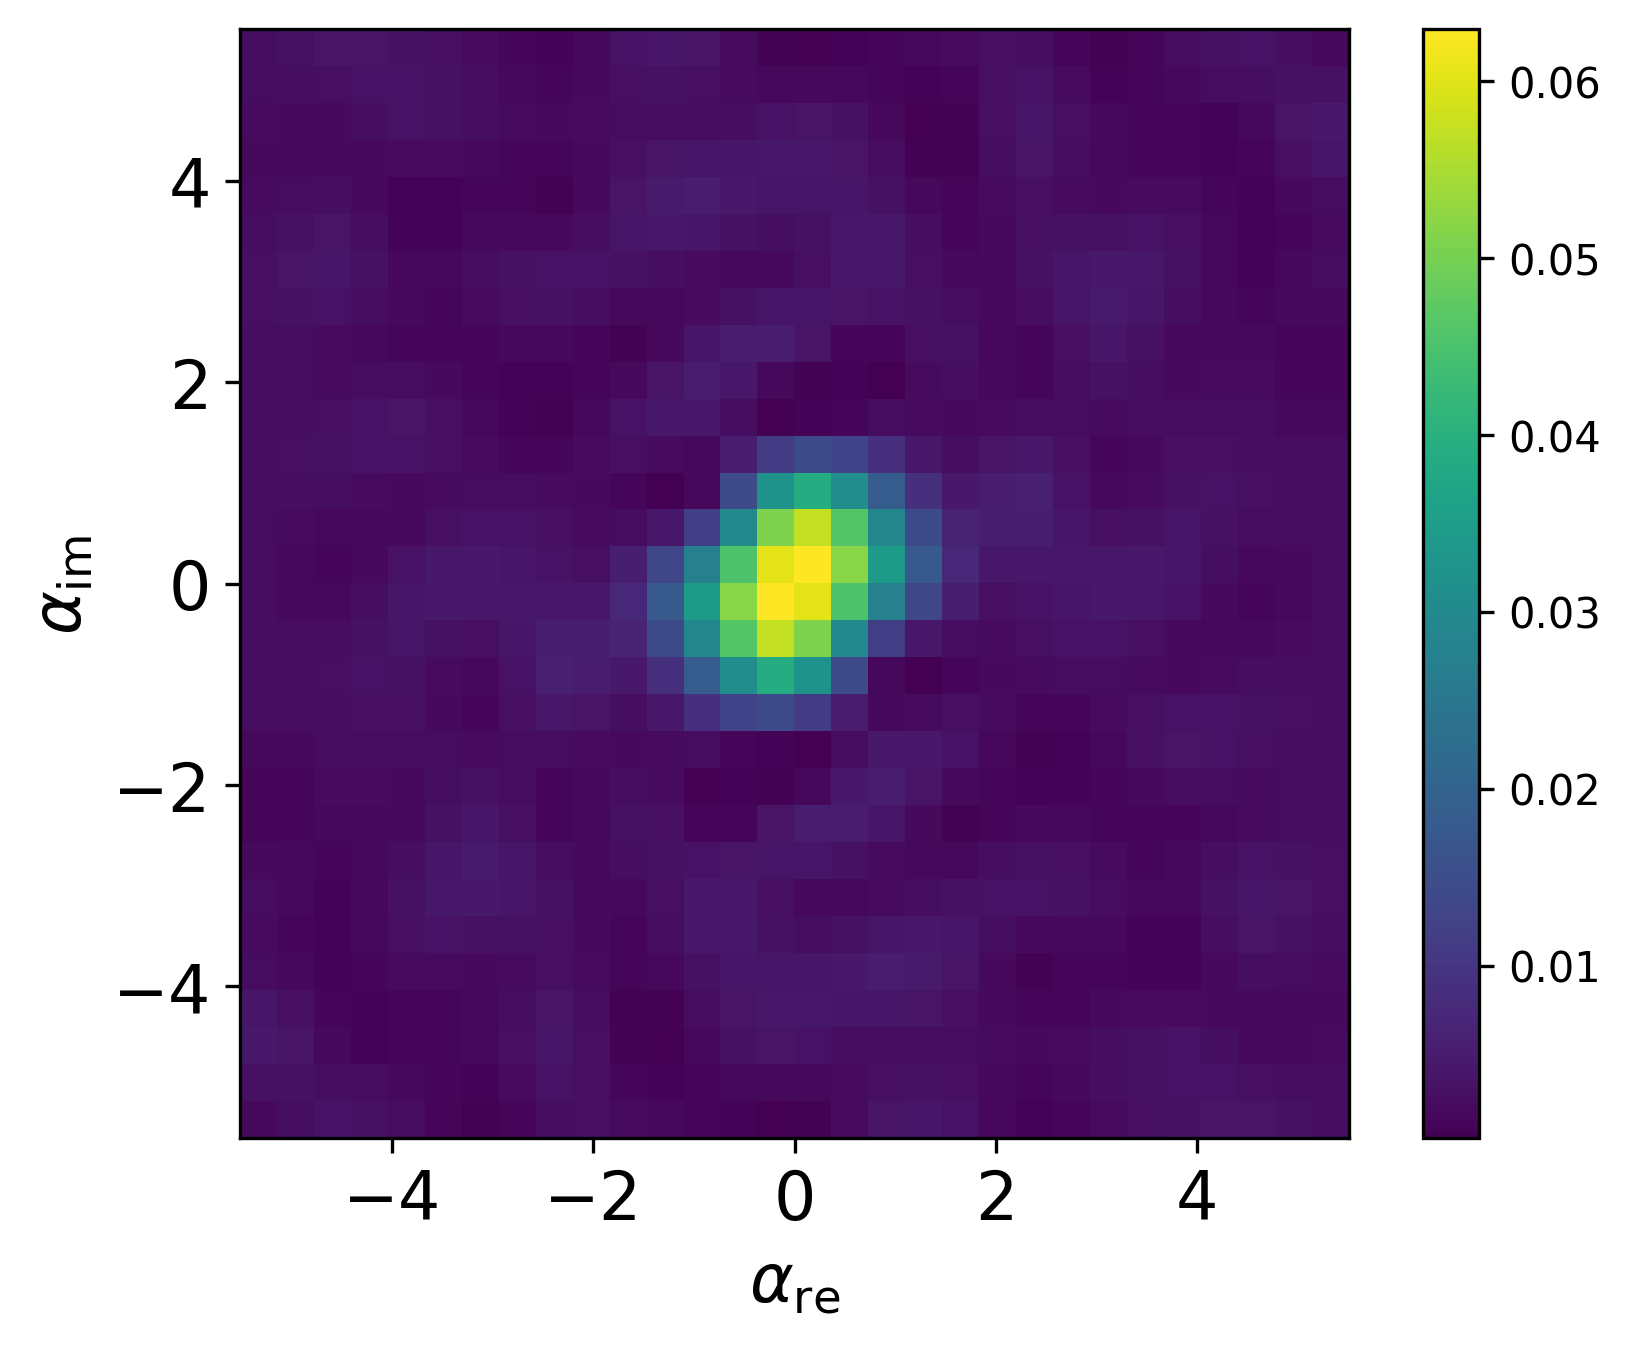

In [8]:
# pmt_count_tmp=pmt_count.copy()
pmt_count_tmp=pmt_interpolate.copy()

pmt_count_tmp=np.nan_to_num(pmt_count_tmp, nan=0)
fft_tmp=np.fft.ifft2(pmt_count_tmp-offset)



fft_tmp=np.fft.fftshift(fft_tmp)

beta=np.linspace(-beta_range1, beta_range1, len(pmt_count))
alpha=np.fft.fftshift(np.fft.fftfreq(len(beta), beta[1]-beta[0]))*4


fft_interpolate=interpolate_2d(np.abs(fft_tmp), upscale_factor=2)

plt.figure(dpi=300)
plt.imshow(np.abs(fft_interpolate), cmap=cmap,extent=[alpha[0], alpha[-1], alpha[0], alpha[-1]])

plt.xlabel('$\\alpha_{\\rm re}$',fontsize=16)
plt.ylabel('$\\alpha_{\\rm im}$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar()
